Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

## Instructions
0. If you haven't already, follow [the setup instructions here](https://jennselby.github.io/MachineLearningCourseNotes/#setting-up-python3) to get all necessary software installed.
0. To be able to run the animation below, make sure you have the latest version of matplotlib, by running `python3 -m pip install matplotlib --upgrade`
0. Read through the code in the following sections:
    * [Define game environment and replay classes](#Define-game-environment-and-replay-classes)
    * [Define functions to create model, train, and visualize](#Define-functions-to-create-model,-train,-and-visualize)
    * [Try untrained model](#Try-untrained-model)
    * [Train and assess model](#Train-and-assess-model)
0. Complete some of the [Possible Exercises](#Possible-Exercises)

In [ ]:
%matplotlib inline
import json
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display
from tensorflow import device
from tensorflow import test

## Define game environment and replay classes
The idea in this FallingFruit game is that the user has to move to try to dodge the fruit. If they dodge it, they win and the game is over. If they get hit by it, they lose and the game is over. We are trying to teach the computer to play this game.

In [ ]:
class FallingFruit(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_player_center = 1
        self.max_player_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, player_center = self.state
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and player and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, player_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, player_center-1:player_center + 2] = 1  # draw 3-pixel player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was dodged, -1 if it hit, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, player_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - player_center) <= 1:
                return -1 # it was hit by fruit
            else:
                return 1 # it dodged the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([fruit_x, fruit_y, player_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




##  Define functions to create model, train, and visualize

In [ ]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10
print_freq = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(Adam(), "mse")

    # Define environment/game
    env = FallingFruit(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    else:
        # find which action the model currently thinks is best from this state
        q = model.predict([starting_observation])
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards))
            rewards = []


def create_animation(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Try untrained model

In [ ]:
modeld, envd, exp_replayd = build_model()

Rewards in Animation: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


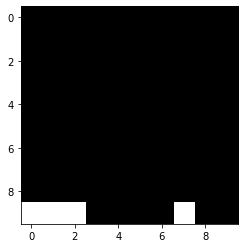

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

## Train and assess model

See how much better it is at dodging the fruit

In [ ]:
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=400)
  animation = create_animation(model, env, num_episodes=10)
  IPython.display.HTML(animation.to_jshtml())

Episodes 0001-0010/0400 | Loss 0.0342 | Rewards [1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
Episodes 0011-0020/0400 | Loss 0.0131 | Rewards [1, -1, -1, -1, 1, -1, -1, 1, 1, 1]
Episodes 0021-0030/0400 | Loss 0.0222 | Rewards [-1, -1, -1, 1, 1, -1, 1, -1, -1, 1]
Episodes 0031-0040/0400 | Loss 0.0260 | Rewards [1, -1, 1, 1, -1, 1, 1, 1, 1, -1]
Episodes 0041-0050/0400 | Loss 0.0149 | Rewards [-1, -1, 1, 1, 1, 1, 1, 1, -1, -1]
Episodes 0051-0060/0400 | Loss 0.0241 | Rewards [1, -1, 1, 1, 1, 1, 1, 1, 1, 1]
Episodes 0061-0070/0400 | Loss 0.0270 | Rewards [1, 1, 1, 1, -1, 1, -1, 1, -1, 1]
Episodes 0071-0080/0400 | Loss 0.0072 | Rewards [1, 1, 1, 1, 1, 1, -1, -1, -1, 1]
Episodes 0081-0090/0400 | Loss 0.0060 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, -1]
Episodes 0091-0100/0400 | Loss 0.0440 | Rewards [1, 1, -1, 1, 1, -1, 1, 1, 1, 1]
Episodes 0101-0110/0400 | Loss 0.0050 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Episodes 0111-0120/0400 | Loss 0.0187 | Rewards [1, 1, 1, 1, 1, 1, -1, 1, 1, -1]
Episodes 0121-0130/04

KeyboardInterrupt: ignored

Rewards in Animation: [1, 1, 1, 1, -1, 1, 1, 1, 1, 1]


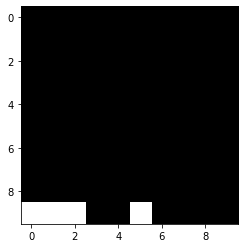

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises
1. Standard Difficulty: Add a validation function, to make it easier to assess models.
1. Advanced Difficulty: We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Standard Difficulty: Change the code so that the player is trying to catch the fruit instead of dodging it.
1. Advanced Difficulty: Change the code so the episode keeps going until the player is hit by the fruit. (To test that this is working, you may want to change the number of episodes in the animation to 1.) How should this change the rewards that the model gets?
1. Advanced Difficulty: Change the game to something entirely different.
1. Standard Difficulty: Try changing how the training works (for instance, changing the discount rate or having the model always choose the action randomly weighted by the action values). Keep notes on what you observe as to how this changes the model performance.

# 1. Validation Function
To add regret, all we need to do is change the training so it takes the maximum possible average reward (in this case that's 1) minus the average rewards.

In [ ]:
def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            regret = 1 - sum(rewards)/10
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {} | Regret {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards, regret))
            rewards = []

In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=30)

Episodes 0001-0010/0030 | Loss 0.0055 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.0
Episodes 0011-0020/0030 | Loss 0.0196 | Rewards [1, -1, 1, 1, 1, 1, -1, 1, 1, 1] | Regret 0.4
Episodes 0021-0030/0030 | Loss 0.0120 | Rewards [1, 1, 1, 1, 1, 1, -1, -1, -1, 1] | Regret 0.6


That seems to work about right, but why is the model getting worse as it's trained?

# 2. Convolutional NN
We just need to change the model.

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.optimizers import SGD

class FallingFruitConv(FallingFruit):
    def observe(self):
        '''
        Returns the current canvas, as a 3D array, of shape (10,10,1).
        '''
        canvas = [self._draw_state()]
        canvas = np.expand_dims(canvas, axis=3) # because Conv2D requires a 3D array ironically
        return canvas
class ExperienceReplayConv(ExperienceReplay):
    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels on the side of the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim, env_dim, 1))  # had to change this inputs shape
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets

def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Conv2D(input_shape=(grid_size, grid_size, 1), filters=4, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(SGD(), "mse")

    # Define environment/game
    env = FallingFruitConv(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplayConv(max_memory=max_memory)
    
    return model, env, exp_replay

In [ ]:
model, env, exp_replay = build_model()

In [ ]:
env.observe()

array([[[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 10, 10, 4)         40        
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               40100     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 303       
Total params: 40,443
Trainable params: 40,443
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modeld.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 303       
Total params: 20,503
Trainable params: 20,503
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

Episodes 0001-0010/0100 | Loss 0.0205 | Rewards [1, 1, 1, 1, 1, -1, -1, 1, 1, 1] | Regret 0.4
Episodes 0011-0020/0100 | Loss 0.0116 | Rewards [1, 1, -1, 1, 1, 1, 1, -1, 1, -1] | Regret 0.6
Episodes 0021-0030/0100 | Loss 0.0286 | Rewards [-1, 1, 1, 1, -1, 1, 1, -1, -1, 1] | Regret 0.8
Episodes 0031-0040/0100 | Loss 0.0100 | Rewards [1, -1, 1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.19999999999999996
Episodes 0041-0050/0100 | Loss 0.0419 | Rewards [-1, -1, -1, -1, -1, 1, -1, 1, -1, 1] | Regret 1.4
Episodes 0051-0060/0100 | Loss 0.0419 | Rewards [1, 1, -1, -1, 1, 1, 1, 1, 1, 1] | Regret 0.4
Episodes 0061-0070/0100 | Loss 0.0372 | Rewards [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.19999999999999996
Episodes 0071-0080/0100 | Loss 0.0559 | Rewards [-1, 1, 1, 1, 1, 1, -1, 1, -1, 1] | Regret 0.6
Episodes 0081-0090/0100 | Loss 0.0340 | Rewards [1, 1, 1, 1, 1, 1, -1, 1, -1, 1] | Regret 0.4
Episodes 0091-0100/0100 | Loss 0.0462 | Rewards [1, 1, 1, 1, 1, 1, -1, 1, 1, 1] | Regret 0.19999999999999996


Interestingly enough, the convolutional model had more parameters but did not perform better, and may have even been slightly worse than the normal method. I genuinely wonder why. I tried again but with less dense units and more convlutional.

In [ ]:
def create_animationConv(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict(observation)
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation[0,:,:,0])
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

Rewards in Animation: [1, 1, 1, 1, -1, 1, 1, 1, 1, 1]


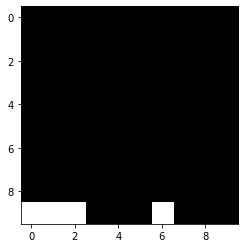

In [ ]:
animation = create_animationConv(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

In [ ]:
def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Conv2D(input_shape=(grid_size, grid_size, 1), filters=8, kernel_size=4, strides=2, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(SGD(), "mse")

    # Define environment/game
    env = FallingFruitConv(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplayConv(max_memory=max_memory)
    
    return model, env, exp_replay

In [ ]:
model, env, exp_replay = build_model()

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 5, 5, 8)           136       
_________________________________________________________________
flatten_4 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 153       
Total params: 10,339
Trainable params: 10,339
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

Episodes 0001-0010/0100 | Loss 0.0597 | Rewards [-1, 1, 1, 1, 1, 1, 1, 1, 1, -1]
Episodes 0011-0020/0100 | Loss 0.0457 | Rewards [1, 1, 1, 1, -1, -1, 1, 1, 1, 1]
Episodes 0021-0030/0100 | Loss 0.0499 | Rewards [1, 1, 1, -1, 1, 1, -1, 1, 1, 1]
Episodes 0031-0040/0100 | Loss 0.0707 | Rewards [1, -1, -1, -1, 1, 1, 1, 1, 1, 1]
Episodes 0041-0050/0100 | Loss 0.0284 | Rewards [1, 1, 1, 1, 1, 1, -1, -1, 1, -1]
Episodes 0051-0060/0100 | Loss 0.0451 | Rewards [1, -1, 1, 1, 1, -1, 1, -1, 1, 1]
Episodes 0061-0070/0100 | Loss 0.0218 | Rewards [-1, -1, 1, 1, 1, -1, 1, 1, -1, 1]
Episodes 0071-0080/0100 | Loss 0.0490 | Rewards [1, -1, 1, -1, 1, 1, 1, 1, 1, -1]
Episodes 0081-0090/0100 | Loss 0.0269 | Rewards [1, 1, 1, 1, -1, 1, 1, 1, -1, -1]
Episodes 0091-0100/0100 | Loss 0.0162 | Rewards [1, -1, 1, 1, -1, -1, 1, 1, 1, 1]


This reduced convolutional model performed just about as well as the previous one. However, I think I know what the issue is with all the models and why it takes so long to train: it's because 7 turns are completely wasted. The player should know where to go even if it sees the falling cube for the first time only in row 7 (going down). However we are training the model on a bunch of unnecessary information which just slows it down. That's why I'm thinking of having my next iteration look at just the bottom 4 rows.

In [ ]:
class FallingFruitShort(object):
    def __init__(self, grid_size=10, view_height=4):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.height = view_height
        self.min_player_center = 1
        self.max_player_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, player_center = self.state
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and player and
        0s (black squares) everywhere else.
        '''
        im_size = (self.height, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, player_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, player_center-1:player_center + 2] = 1  # draw 3-pixel player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was dodged, -1 if it hit, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, player_center = self.state
        if fruit_y == self.height-1:
            if abs(fruit_x - player_center) <= 1:
                return -1 # it was hit by fruit
            else:
                return 1 # it dodged the fruit
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = [self._draw_state()]
        canvas = np.expand_dims(canvas, axis=3) # because Conv2D requires a 3D array ironically
        return canvas

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([fruit_x, fruit_y, player_center])


class ExperienceReplayShort(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        #env_width = self.memory[0][0][0].shape[1] # width
        #env_height = self.memory[0][0][0].shape[0] # height
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, 4, 10, 1))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets

In [ ]:
# parameters
# epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
# num_actions = 3  # [move_left, stay, move_right]
# max_memory = 500
# hidden_size = 100
# batch_size = 50
# grid_size = 10
# print_freq = 10
view_height = 4


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Conv2D(input_shape=(view_height, grid_size, 1), filters=8, kernel_size=4, strides=1, padding='same', activation='relu'))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(SGD(), "mse")

    # Define environment/game
    env = FallingFruitShort(grid_size, view_height)

    # Initialize experience replay object
    exp_replay = ExperienceReplayShort(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    else:
        # find which action the model currently thinks is best from this state
        q = model.predict([starting_observation])
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            regret = 1 - sum(rewards)/print_freq
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {} | Regret {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards, regret))
            rewards = []


def create_animationConv(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict(observation)
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((view_height, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation[0,:,:,0])
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

In [ ]:
model, env, exp_replay = build_model()

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 4, 10, 8)          136       
_________________________________________________________________
flatten_6 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                16050     
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 153       
Total params: 16,339
Trainable params: 16,339
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

Episodes 0001-0010/0100 | Loss 0.0699 | Rewards [1, 1, -1, -1, -1, 1, -1, 1, 1, -1] | Regret 1.0
Episodes 0011-0020/0100 | Loss 0.1087 | Rewards [1, 1, -1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.19999999999999996
Episodes 0021-0030/0100 | Loss 0.1150 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.0
Episodes 0031-0040/0100 | Loss 0.0659 | Rewards [1, 1, 1, 1, -1, 1, 1, -1, 1, 1] | Regret 0.4
Episodes 0041-0050/0100 | Loss 0.1218 | Rewards [1, 1, 1, 1, -1, -1, -1, 1, 1, 1] | Regret 0.6
Episodes 0051-0060/0100 | Loss 0.0947 | Rewards [-1, 1, -1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.4
Episodes 0061-0070/0100 | Loss 0.0880 | Rewards [-1, 1, 1, 1, 1, -1, 1, 1, 1, 1] | Regret 0.4
Episodes 0071-0080/0100 | Loss 0.1024 | Rewards [-1, 1, 1, -1, 1, 1, 1, -1, 1, 1] | Regret 0.6
Episodes 0081-0090/0100 | Loss 0.1106 | Rewards [1, -1, 1, 1, 1, -1, 1, 1, 1, -1] | Regret 0.6
Episodes 0091-0100/0100 | Loss 0.0740 | Rewards [1, 1, 1, 1, 1, 1, 1, -1, 1, 1] | Regret 0.19999999999999996


In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

Episodes 0001-0010/0100 | Loss 0.1226 | Rewards [1, -1, 1, 1, 1, 1, -1, 1, -1, 1] | Regret 0.6
Episodes 0011-0020/0100 | Loss 0.0771 | Rewards [-1, 1, -1, 1, 1, -1, 1, -1, 1, 1] | Regret 0.8
Episodes 0021-0030/0100 | Loss 0.1170 | Rewards [-1, 1, 1, 1, -1, -1, 1, 1, -1, -1] | Regret 1.0
Episodes 0031-0040/0100 | Loss 0.1212 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, -1] | Regret 0.19999999999999996
Episodes 0041-0050/0100 | Loss 0.0722 | Rewards [1, 1, 1, 1, 1, 1, -1, 1, 1, 1] | Regret 0.19999999999999996
Episodes 0051-0060/0100 | Loss 0.1275 | Rewards [1, 1, 1, -1, 1, 1, -1, -1, 1, 1] | Regret 0.6
Episodes 0061-0070/0100 | Loss 0.1356 | Rewards [-1, 1, 1, 1, 1, 1, 1, 1, 1, -1] | Regret 0.4
Episodes 0071-0080/0100 | Loss 0.0836 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.0
Episodes 0081-0090/0100 | Loss 0.0670 | Rewards [1, 1, 1, 1, 1, 1, 1, -1, 1, -1] | Regret 0.4
Episodes 0091-0100/0100 | Loss 0.1213 | Rewards [1, 1, 1, 1, 1, 1, 1, -1, -1, -1] | Regret 0.6


Rewards in Animation: [1, 1, 1, 1, 1, -1, 1, 1, 1, 1]


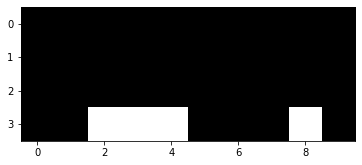

In [ ]:
animation = create_animationConv(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

What confuses me is how to a human like me this seems mind bogglingly simple: just move in the direction opposite to where the falling cube is. I would expect the CNN to looks something like the following: the kernels on the left of the player view have strong weights to to the right action, while those on the right weigh more heavily towards the left action. I am honestly not sure why the model is not interpreting the game this way. That's why I was thinking of inputting just the cube's x position, so the y doesn't confuse the model. The y cooridnate shouldn't be impactful on the player's moves anyway in my opinion.

In [ ]:
class FallingFruitSDense(FallingFruitShort):
    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1,-1))


class ExperienceReplaySDense(ExperienceReplayShort):
    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1]
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets

In [ ]:
# parameters
# epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
# num_actions = 3  # [move_left, stay, move_right]
# max_memory = 500
# hidden_size = 100
# batch_size = 50
# grid_size = 10
# print_freq = 10
view_height = 3


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(10, input_shape=(grid_size*view_height,), activation='relu'))
    model.add(Dense(num_actions))
    model.compile(SGD(), "mse")

    # Define environment/game
    env = FallingFruitSDense(grid_size, view_height)

    # Initialize experience replay object
    exp_replay = ExperienceReplaySDense(max_memory=max_memory)
    
    return model, env, exp_replay

def create_animationSDense(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((view_height, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((view_height, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

In [ ]:
model, env, exp_replay = build_model()

In [ ]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 10)                310       
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 33        
Total params: 343
Trainable params: 343
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

Episodes 0001-0010/0100 | Loss 0.1673 | Rewards [1, 1, -1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.19999999999999996
Episodes 0011-0020/0100 | Loss 0.1493 | Rewards [1, 1, -1, 1, 1, 1, -1, 1, 1, 1] | Regret 0.4
Episodes 0021-0030/0100 | Loss 0.1516 | Rewards [1, -1, -1, 1, 1, 1, -1, -1, -1, 1] | Regret 1.0
Episodes 0031-0040/0100 | Loss 0.1267 | Rewards [1, -1, 1, 1, 1, -1, 1, 1, 1, -1] | Regret 0.6
Episodes 0041-0050/0100 | Loss 0.2160 | Rewards [-1, 1, 1, 1, 1, 1, -1, -1, -1, 1] | Regret 0.8
Episodes 0051-0060/0100 | Loss 0.1588 | Rewards [1, 1, 1, -1, 1, 1, 1, -1, -1, -1] | Regret 0.8
Episodes 0061-0070/0100 | Loss 0.1750 | Rewards [1, 1, 1, 1, 1, -1, -1, 1, 1, 1] | Regret 0.4
Episodes 0071-0080/0100 | Loss 0.1765 | Rewards [1, 1, 1, 1, -1, 1, -1, 1, -1, -1] | Regret 0.8
Episodes 0081-0090/0100 | Loss 0.1701 | Rewards [1, -1, 1, -1, 1, 1, 1, 1, 1, -1] | Regret 0.6
Episodes 0091-0100/0100 | Loss 0.1178 | Rewards [1, -1, 1, -1, 1, 1, -1, -1, -1, 1] | Regret 1.0


In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

Episodes 0001-0010/0100 | Loss 0.1405 | Rewards [1, -1, -1, 1, 1, 1, -1, -1, 1, 1] | Regret 0.8
Episodes 0011-0020/0100 | Loss 0.1578 | Rewards [1, -1, 1, 1, 1, -1, -1, 1, 1, -1] | Regret 0.8
Episodes 0021-0030/0100 | Loss 0.1284 | Rewards [-1, -1, 1, -1, 1, 1, 1, -1, 1, -1] | Regret 1.0
Episodes 0031-0040/0100 | Loss 0.1618 | Rewards [1, -1, -1, 1, 1, 1, 1, 1, 1, -1] | Regret 0.6
Episodes 0041-0050/0100 | Loss 0.1789 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, -1, -1] | Regret 0.4
Episodes 0051-0060/0100 | Loss 0.1602 | Rewards [1, 1, 1, 1, 1, 1, -1, -1, -1, 1] | Regret 0.6
Episodes 0061-0070/0100 | Loss 0.1453 | Rewards [-1, -1, -1, -1, -1, -1, 1, 1, 1, 1] | Regret 1.2
Episodes 0071-0080/0100 | Loss 0.1098 | Rewards [1, -1, 1, -1, 1, 1, 1, 1, 1, 1] | Regret 0.4
Episodes 0081-0090/0100 | Loss 0.1665 | Rewards [-1, 1, 1, 1, -1, 1, -1, 1, 1, 1] | Regret 0.6
Episodes 0091-0100/0100 | Loss 0.1664 | Rewards [1, 1, -1, 1, 1, 1, -1, 1, 1, 1] | Regret 0.4


In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100, pretrain_episodes=0)

Episodes 0001-0010/0100 | Loss 0.1644 | Rewards [1, 1, 1, 1, -1, 1, 1, 1, -1, -1] | Regret 0.6
Episodes 0011-0020/0100 | Loss 0.1411 | Rewards [1, 1, -1, 1, 1, -1, -1, -1, -1, 1] | Regret 1.0
Episodes 0021-0030/0100 | Loss 0.1598 | Rewards [-1, -1, 1, 1, 1, -1, -1, 1, 1, 1] | Regret 0.8
Episodes 0031-0040/0100 | Loss 0.1804 | Rewards [-1, 1, -1, 1, 1, 1, 1, -1, 1, -1] | Regret 0.8
Episodes 0041-0050/0100 | Loss 0.1104 | Rewards [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.0
Episodes 0051-0060/0100 | Loss 0.1593 | Rewards [1, 1, 1, 1, -1, 1, 1, -1, 1, -1] | Regret 0.6
Episodes 0061-0070/0100 | Loss 0.1983 | Rewards [1, 1, 1, -1, 1, 1, -1, 1, -1, -1] | Regret 0.8
Episodes 0071-0080/0100 | Loss 0.1168 | Rewards [-1, 1, 1, 1, 1, 1, 1, 1, 1, 1] | Regret 0.19999999999999996
Episodes 0081-0090/0100 | Loss 0.1327 | Rewards [1, -1, 1, 1, -1, -1, -1, 1, 1, 1] | Regret 0.8
Episodes 0091-0100/0100 | Loss 0.2072 | Rewards [1, 1, -1, 1, 1, -1, -1, 1, -1, 1] | Regret 0.8


Seriously how does this take the same amount of time as the other versions?? I could calculate these predictions by hand!

Rewards in Animation: [1, 1, 1, -1, 1, 1, -1, -1, -1, 1]


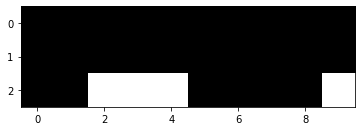

In [ ]:
animation = create_animationSDense(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

In [ ]:
view_height = 4

# 5. Space Invaders
For the space invaders game I want to try a new strategy of using colors which I believe will improve the model's efficacy a ton. The spaceship, the bullets, and the aliens, will be 3 different colors. The spaceship is a single pixel and shoots out a stream of one bullet per tick. One round is an alien dropped in a random spot. One point is rewarded if the alien is shot, and one point is lost if the alien that gets to the bottom. Bullets and aliens collide when they are in the same spot or just passed through each other.

In [ ]:
class SpaceInvaders(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_player_center = 0
        self.max_player_center = self.grid_size-1
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state  # list, list, int
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move alien down
        alien_y += 1
        # move bullets up
        bullet_ys = [y-1 for y in bullet_ys]
        # create new bullet
        bullet_ys.append(self.grid_size-2)
        bullet_xs.append(new_player_center)
        # remove collisions
        for x_idx in range(len(bullet_xs)):
          if bullet_xs[x_idx] == alien_x:
            if bullet_ys[x_idx] == alien_y or bullet_ys[x_idx] + 1 == alien_y:
              alien_y = -1 # signals the episode is over
        out = np.asarray([alien_x, alien_y, bullet_xs, bullet_ys, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 3D numpy array with 1s (red, blue, and green squares) at the locations of the bullets, player, and aliens, and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size, 3)
        canvas = np.zeros(im_size)
        
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state
        canvas[alien_y, alien_x, 1] = 1  # draw alien
        for xy in zip(bullet_xs, bullet_ys):
          canvas[xy[1], xy[0], 0] = 1  # draw bullet
        canvas[-1, player_center, 2] = 1  # draw player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the alien was hit, -1 if it wasn't hit, and 0 if it is still in the air.
        '''
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state
        if alien_y == self.grid_size-1:
            return -1  # it didn't hit the alien
        elif alien_y == -1:
          return 1  # it hit the alien
        else:
            return 0  # the alien is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the alien is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        alien_x = random.randint(0, self.grid_size-1)
        alien_y = 0
        bullet_xs = []
        bullet_ys = []
        player_center = int(self.grid_size/2) #random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([alien_x, alien_y, bullet_xs, bullet_ys, player_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




##  Define functions to create model, train, and visualize

In [ ]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10
print_freq = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(3*grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(Adam(), "mse")

    # Define environment/game
    env = SpaceInvaders(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    else:
        # find which action the model currently thinks is best from this state
        q = model.predict([starting_observation])
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards))
            rewards = []


def create_animation(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size, 3)), interpolation='none', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size, 3)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Try untrained model

In [ ]:
model, env, exp_replay = build_model()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Rewards in Animation: [1, -1, -1, -1, -1, 1, 1, -1, 1, -1]


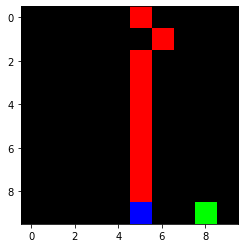

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episodes 0001-0010/0100 | Loss 0.0482 | Rewards [1, 1, -1, -1, -1, 1, -1, 1, -1, -1]
Episodes 0011-0020/0100 | Loss 0.0236 | Rewards [1, -1, -1, 1, 1, 1, -1, 1, -1, -1]
Episodes 0021-0030/0100 | Loss 0.0171 | Rewards [-1, -1, -1, 1, -1, -1, 1, -1, 1, 1]
Episodes 0031-0040/0100 | Loss 0.0296 | Rewards [-1, 1, 1, -1, -1, -1, -1, -1, -1, 1]
Episodes 0041-0050/0100 | Loss 0.0095 | Rewards [-1, -1, -1, -1, 1, -1, -1, 1, -1, -1]
Episodes 0051-0060/0100 | Loss 0.0125 | Rewards [1, 1, -1, 1, -1, -1, 1, 1, -1, 1]
Episodes 0061-0070/0100 | Loss 0.0576 | Rewards [-1, 1, 1, -1, -1, -1, -1, -1, -1, 1]
Episodes 0071-0080/0100 | Loss 0.0147 | Rewards [-1, -1, -1, -1, -1, -1, 1, -1, 1, -1]
Episodes 0081-0090/0100 | Loss 0.0179 | Rewards [1, -1, 1, -1, -1, -1, -1, 1, -1, -1]
Episodes 0091-0100/0100 | Loss 0.0138 | Rewards [-1, -1, -1, -1, -1, 1, -1, -1, 1, -1]
Rewards in Animation: [1, -1, 1, -1, 1, 1, -1, -1, -1, 1]


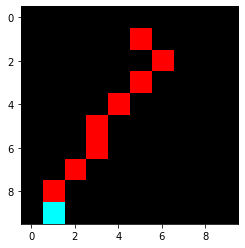

In [ ]:
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)
  animation = create_animation(model, env, num_episodes=10)
  IPython.display.HTML(animation.to_jshtml())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Rewards in Animation: [1, 1, -1, 1, 1, 1, -1, 1, -1, 1]


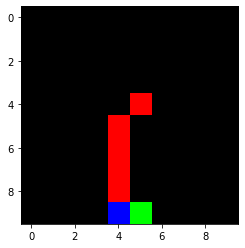

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episodes 0001-0010/0100 | Loss 0.0225 | Rewards [-1, 1, 1, 1, 1, 1, -1, -1, 1, -1]
Episodes 0011-0020/0100 | Loss 0.0095 | Rewards [-1, -1, 1, -1, -1, -1, -1, -1, -1, 1]
Episodes 0021-0030/0100 | Loss 0.0133 | Rewards [1, 1, -1, 1, 1, 1, 1, -1, -1, 1]
Episodes 0031-0040/0100 | Loss 0.0081 | Rewards [1, -1, 1, -1, 1, -1, -1, -1, 1, -1]
Episodes 0041-0050/0100 | Loss 0.0305 | Rewards [-1, -1, 1, 1, -1, 1, 1, 1, -1, -1]
Episodes 0051-0060/0100 | Loss 0.0167 | Rewards [-1, 1, 1, -1, -1, 1, 1, -1, 1, 1]
Episodes 0061-0070/0100 | Loss 0.0170 | Rewards [1, 1, 1, -1, -1, 1, 1, -1, 1, 1]
Episodes 0071-0080/0100 | Loss 0.0216 | Rewards [-1, -1, 1, -1, 1, 1, -1, -1, 1, -1]
Episodes 0081-0090/0100 | Loss 0.0296 | Rewards [1, -1, 1, 1, 1, -1, 1, -1, -1, 1]
Episodes 0091-0100/0100 | Loss 0.0146 | Rewards [1, 1, -1, 1, -1, 1, -1, -1, 1, -1]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Rewards in Animation: [1, 1, 1, 1, 1, 1, 1, -1, -1, 1]


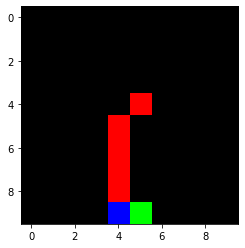

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

The model knows how to move, but oddly enough only moves in one direction. I'm thinking this may have to do with having a set starting position.

# Random Start
A new model that starts player at a random position. This may help revitalize the model so it moves dynamically.

In [ ]:
class SpaceInvaders(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_player_center = 0
        self.max_player_center = self.grid_size-1
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state  # list, list, int
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move alien down
        alien_y += 1
        # move bullets up
        bullet_ys = [y-1 for y in bullet_ys]
        # create new bullet
        bullet_ys.append(self.grid_size-2)
        bullet_xs.append(new_player_center)
        # remove collisions
        for x_idx in range(len(bullet_xs)):
          if bullet_xs[x_idx] == alien_x:
            if bullet_ys[x_idx] == alien_y or bullet_ys[x_idx] + 1 == alien_y:
              alien_y = -1 # signals the episode is over
        out = np.asarray([alien_x, alien_y, bullet_xs, bullet_ys, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 3D numpy array with 1s (red, blue, and green squares) at the locations of the bullets, player, and aliens, and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size, 3)
        canvas = np.zeros(im_size)
        
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state
        canvas[alien_y, alien_x, 1] = 1  # draw alien
        for xy in zip(bullet_xs, bullet_ys):
          canvas[xy[1], xy[0], 0] = 1  # draw bullet
        canvas[-1, player_center, 2] = 1  # draw player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the alien was hit, -1 if it wasn't hit, and 0 if it is still in the air.
        '''
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state
        if alien_y == self.grid_size-1:
            return -1  # it didn't hit the alien
        elif alien_y == -1:
          return 1  # it hit the alien
        else:
            return 0  # the alien is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the alien is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        alien_x = random.randint(0, self.grid_size-1)
        alien_y = 0
        bullet_xs = []
        bullet_ys = []
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([alien_x, alien_y, bullet_xs, bullet_ys, player_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




In [ ]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10
print_freq = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(3*grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(Adam(), "mse")

    # Define environment/game
    env = SpaceInvaders(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    else:
        # find which action the model currently thinks is best from this state
        q = model.predict([starting_observation])
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards))
            rewards = []


def create_animation(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size, 3)), interpolation='none', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size, 3)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

In [ ]:
model, env, exp_replay = build_model()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Rewards in Animation: [-1, 1, 1, -1, -1, -1, -1, -1, -1, 1]


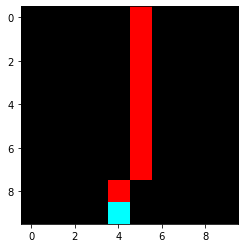

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episodes 0001-0010/0100 | Loss 0.0277 | Rewards [-1, -1, -1, -1, -1, -1, -1, -1, 1, 1]
Episodes 0011-0020/0100 | Loss 0.0283 | Rewards [-1, -1, -1, -1, -1, 1, 1, -1, -1, -1]
Episodes 0021-0030/0100 | Loss 0.0485 | Rewards [-1, -1, -1, 1, -1, -1, -1, -1, 1, 1]
Episodes 0031-0040/0100 | Loss 0.0201 | Rewards [1, -1, -1, -1, 1, -1, -1, 1, 1, 1]
Episodes 0041-0050/0100 | Loss 0.0268 | Rewards [1, -1, -1, -1, 1, 1, -1, -1, -1, -1]
Episodes 0051-0060/0100 | Loss 0.0074 | Rewards [-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
Episodes 0061-0070/0100 | Loss 0.0136 | Rewards [-1, -1, 1, -1, 1, 1, 1, 1, -1, 1]
Episodes 0071-0080/0100 | Loss 0.0278 | Rewards [-1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
Episodes 0081-0090/0100 | Loss 0.0167 | Rewards [-1, 1, 1, 1, -1, 1, -1, 1, -1, 1]
Episodes 0091-0100/0100 | Loss 0.0231 | Rewards [-1, -1, 1, -1, -1, 1, -1, -1, 1, -1]
Rewards in Animation: [1, 1, 1, -1, -1, 1, -1, -1, -1, -1]


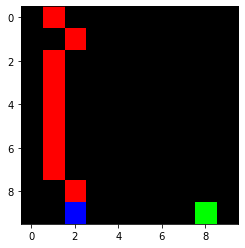

In [ ]:
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)
  animation = create_animation(model, env, num_episodes=10)
  IPython.display.HTML(animation.to_jshtml())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Rewards in Animation: [1, -1, -1, 1, 1, 1, -1, -1, -1, 1]


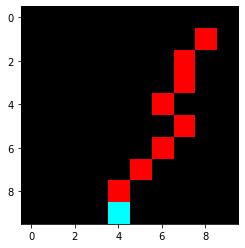

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episodes 0001-0010/0100 | Loss 0.0197 | Rewards [-1, 1, 1, 1, -1, 1, -1, -1, -1, 1]
Episodes 0011-0020/0100 | Loss 0.0269 | Rewards [1, -1, 1, -1, -1, -1, -1, 1, -1, 1]
Episodes 0021-0030/0100 | Loss 0.0130 | Rewards [1, -1, 1, -1, -1, -1, 1, -1, -1, -1]
Episodes 0031-0040/0100 | Loss 0.0158 | Rewards [-1, -1, 1, -1, 1, 1, -1, -1, -1, -1]
Episodes 0041-0050/0100 | Loss 0.0197 | Rewards [-1, 1, 1, -1, 1, 1, -1, 1, 1, 1]
Episodes 0051-0060/0100 | Loss 0.0154 | Rewards [-1, 1, 1, -1, -1, 1, 1, -1, -1, -1]
Episodes 0061-0070/0100 | Loss 0.0313 | Rewards [1, 1, 1, 1, -1, 1, -1, -1, 1, 1]
Episodes 0071-0080/0100 | Loss 0.0156 | Rewards [-1, 1, -1, -1, -1, 1, -1, -1, -1, -1]
Episodes 0081-0090/0100 | Loss 0.0159 | Rewards [-1, 1, 1, -1, -1, -1, -1, 1, -1, -1]
Episodes 0091-0100/0100 | Loss 0.0107 | Rewards [1, 1, -1, 1, 1, -1, -1, 1, -1, -1]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Rewards in Animation: [1, -1, 1, -1, 1, -1, 1, -1, -1, -1]


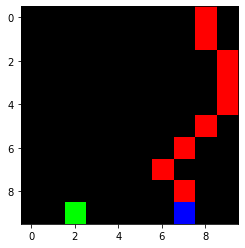

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

This does show signs of dynamic movement, but it's still not very good. Something I noticed is that due to the way I programmed the collisions, the alien ends up at the bottom (I put it at -1 y when it dies). Maybe this is messing up the model? I decided that removing making collisions disappear is not actually relevant to the game and so I remove it.

# Collisions Don't Disappear
I changed the game so it doesn't remove collisions and the logic becomes a part of the reward system.

In [ ]:
class SpaceInvaders(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_player_center = 0
        self.max_player_center = self.grid_size-1
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state  # list, list, int
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move alien down
        alien_y += 1
        # move bullets up
        bullet_ys = [y-1 for y in bullet_ys]
        # create new bullet
        bullet_ys.append(self.grid_size-2)
        bullet_xs.append(new_player_center)
        out = np.asarray([alien_x, alien_y, bullet_xs, bullet_ys, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 3D numpy array with 1s (red, blue, and green squares) at the locations of the bullets, player, and aliens, and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size, 3)
        canvas = np.zeros(im_size)
        
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state
        canvas[alien_y, alien_x, 1] = 1  # draw alien
        for xy in zip(bullet_xs, bullet_ys):
          canvas[xy[1], xy[0], 0] = 1  # draw bullet
        canvas[-1, player_center, 2] = 1  # draw player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the alien was hit, -1 if it wasn't hit, and 0 if it is still in the air.
        '''
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state
        for x_idx in range(len(bullet_xs)):
          if bullet_xs[x_idx] == alien_x:
            if bullet_ys[x_idx] == alien_y or bullet_ys[x_idx] + 1 == alien_y:
              return 1 # it hit the alien
        
        if alien_y == self.grid_size-1:
            return -1  # it didn't hit the alien
        else:
            return 0  # the alien is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the alien is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        alien_x = random.randint(0, self.grid_size-1)
        alien_y = 0
        bullet_xs = []
        bullet_ys = []
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([alien_x, alien_y, bullet_xs, bullet_ys, player_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




In [ ]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10
print_freq = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(3*grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(Adam(), "mse")

    # Define environment/game
    env = SpaceInvaders(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    else:
        # find which action the model currently thinks is best from this state
        q = model.predict([starting_observation])
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards))
            rewards = []


def create_animation(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size, 3)), interpolation='none', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size, 3)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

In [ ]:
model, env, exp_replay = build_model()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
Rewards in Animation: [1, -1, -1, -1, 1, 1, -1, -1, -1, 1]


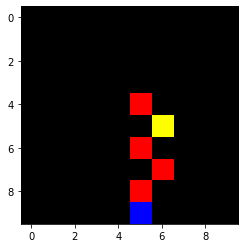

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episodes 0001-0010/0100 | Loss 0.0519 | Rewards [-1, 1, 1, 1, 1, -1, -1, 1, -1, 1]
Episodes 0011-0020/0100 | Loss 0.0422 | Rewards [-1, 1, -1, 1, 1, -1, -1, -1, 1, -1]
Episodes 0021-0030/0100 | Loss 0.0318 | Rewards [-1, 1, -1, 1, 1, -1, 1, 1, -1, 1]
Episodes 0031-0040/0100 | Loss 0.0225 | Rewards [1, -1, -1, -1, -1, -1, -1, -1, 1, 1]
Episodes 0041-0050/0100 | Loss 0.0221 | Rewards [-1, -1, -1, 1, -1, 1, -1, -1, 1, 1]
Episodes 0051-0060/0100 | Loss 0.0172 | Rewards [1, -1, 1, 1, 1, 1, -1, -1, -1, -1]
Episodes 0061-0070/0100 | Loss 0.0160 | Rewards [-1, -1, -1, -1, -1, -1, -1, -1, -1, 1]
Episodes 0071-0080/0100 | Loss 0.0107 | Rewards [-1, -1, 1, 1, -1, -1, 1, 1, 1, -1]
Episodes 0081-0090/0100 | Loss 0.0303 | Rewards [1, 1, -1, -1, 1, 1, -1, 1, -1, 1]
Episodes 0091-0100/0100 | Loss 0.0095 | Rewards [1, -1, 1, -1, -1, -1, -1, -1, -1, -1]
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)

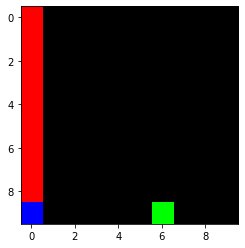

In [ ]:
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)
  animation = create_animation(model, env, num_episodes=10)
  IPython.display.HTML(animation.to_jshtml())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
Rewards in Animation: [1, 1, -1, 1, 1, -1, -1, 1, 1, 1]


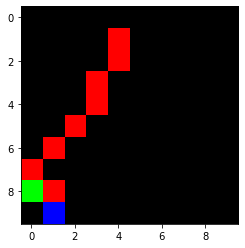

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episodes 0001-0010/0100 | Loss 0.0362 | Rewards [-1, -1, -1, 1, -1, -1, 1, 1, -1, -1]
Episodes 0011-0020/0100 | Loss 0.0095 | Rewards [-1, -1, -1, -1, -1, -1, -1, 1, -1, 1]
Episodes 0021-0030/0100 | Loss 0.0326 | Rewards [-1, 1, -1, -1, -1, 1, -1, -1, -1, -1]
Episodes 0031-0040/0100 | Loss 0.0273 | Rewards [-1, -1, 1, -1, 1, 1, 1, 1, -1, -1]
Episodes 0041-0050/0100 | Loss 0.0221 | Rewards [-1, -1, -1, -1, -1, -1, -1, -1, -1, 1]
Episodes 0051-0060/0100 | Loss 0.0112 | Rewards [-1, -1, -1, 1, -1, 1, -1, -1, 1, -1]
Episodes 0061-0070/0100 | Loss 0.0247 | Rewards [-1, 1, -1, -1, 1, -1, -1, -1, -1, 1]
Episodes 0071-0080/0100 | Loss 0.0123 | Rewards [1, -1, -1, -1, -1, -1, -1, 1, -1, -1]
Episodes 0081-0090/0100 | Loss 0.0082 | Rewards [-1, 1, -1, -1, -1, -1, 1, -1, -1, -1]
Episodes 0091-0100/0100 | Loss 0.0172 | Rewards [-1, -1, 1, -1, -1, -1, 1, 1, -1, -1]
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(1, 300)
(

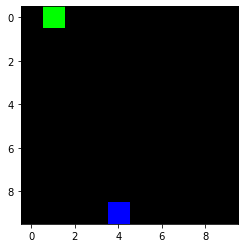

In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)
  animation = create_animation(model, env, num_episodes=10)

In [ ]:
IPython.display.HTML(animation.to_jshtml())

There is some minor improvement in this model, but not very substanstial, although I should probably expect that given the change was minute.

# Different Model Size
You may have noticed that the original fruit drop model has 100 units in the hidden layers. While this does too, it also had 3 times as many inputs. That's why I thought it would be better to have 300 unit hidden layers. However this ended up making the model worse, so then I tried with 50 units in the hidden layer instead.

In [ ]:
class SpaceInvaders(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_player_center = 0
        self.max_player_center = self.grid_size-1
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state  # list, list, int
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move alien down
        alien_y += 1
        # move bullets up
        bullet_ys = [y-1 for y in bullet_ys]
        # create new bullet
        bullet_ys.append(self.grid_size-2)
        bullet_xs.append(new_player_center)
        out = np.asarray([alien_x, alien_y, bullet_xs, bullet_ys, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 3D numpy array with 1s (red, blue, and green squares) at the locations of the bullets, player, and aliens, and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size, 3)
        canvas = np.zeros(im_size)
        
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state
        canvas[alien_y, alien_x, 1] = 1  # draw alien
        for xy in zip(bullet_xs, bullet_ys):
          canvas[xy[1], xy[0], 0] = 1  # draw bullet
        canvas[-1, player_center, 2] = 1  # draw player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the alien was hit, -1 if it wasn't hit, and 0 if it is still in the air.
        '''
        alien_x, alien_y, bullet_xs, bullet_ys, player_center = self.state
        for x_idx in range(len(bullet_xs)):
          if bullet_xs[x_idx] == alien_x:
            if bullet_ys[x_idx] == alien_y or bullet_ys[x_idx] + 1 == alien_y:
              return 1 # it hit the alien
        
        if alien_y == self.grid_size-1:
            return -1  # it didn't hit the alien
        else:
            return 0  # the alien is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the alien is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        alien_x = random.randint(0, self.grid_size-1)
        alien_y = 0
        bullet_xs = []
        bullet_ys = []
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([alien_x, alien_y, bullet_xs, bullet_ys, player_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




In [ ]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10
print_freq = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    model.add(Dense(50, input_shape=(3*grid_size**2,), activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(Adam(), "mse")

    # Define environment/game
    env = SpaceInvaders(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    else:
        # find which action the model currently thinks is best from this state
        q = model.predict([starting_observation])
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = take_step(exp_replay, model, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards))
            rewards = []


def create_animation(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size, 3)), interpolation='none', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size, 3)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

In [ ]:
model, env, exp_replay = build_model()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Rewards in Animation: [-1, 1, 1, -1, -1, 1, -1, 1, -1, -1]


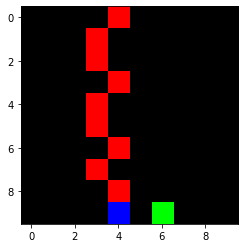

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

In [ ]:
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episodes 0001-0010/0100 | Loss 0.0315 | Rewards [-1, 1, -1, -1, 1, -1, 1, 1, -1, -1]
Episodes 0011-0020/0100 | Loss 0.0447 | Rewards [-1, 1, 1, -1, -1, -1, -1, 1, -1, -1]
Episodes 0021-0030/0100 | Loss 0.0534 | Rewards [1, 1, -1, 1, 1, -1, -1, 1, -1, -1]
Episodes 0031-0040/0100 | Loss 0.0458 | Rewards [1, 1, 1, -1, -1, -1, -1, 1, -1, -1]
Episodes 0041-0050/0100 | Loss 0.0620 | Rewards [1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
Episodes 0051-0060/0100 | Loss 0.0527 | Rewards [-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
Episodes 0061-0070/0100 | Loss 0.0165 | Rewards [1, 1, -1, 1, -1, -1, 1, 1, 1, -1]
Episodes 0071-0080/0100 | Loss 0.0362 | Rewards [-1, 1, -1, -1, 1, -1, 1, -1, -1, 1]
Episodes 0081-0090/0100 | Loss 0.0169 | Rewards [-1, 1, -1, -1, -1, -1, 1, -1, -1, 1]
Episodes 0091-0100/0100 | Loss 0.0279 | Rewards [1, 1, 1, -1, -1, 1, 1, -1, -1, -1]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Rewards in Animation: [-1, 1, 1, 1, -1, -1, 1, 1, 1, -1]


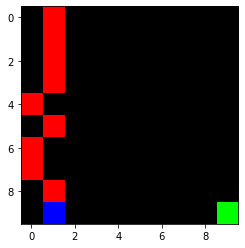

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

In [ ]:
with device('/device:GPU:0'):
  train_model(model, env, exp_replay, num_episodes=100)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Episodes 0001-0010/0100 | Loss 0.0565 | Rewards [1, -1, -1, -1, -1, 1, 1, -1, -1, -1]
Episodes 0011-0020/0100 | Loss 0.0256 | Rewards [1, 1, -1, -1, 1, -1, 1, -1, -1, -1]
Episodes 0021-0030/0100 | Loss 0.0257 | Rewards [-1, 1, -1, 1, 1, -1, 1, -1, -1, -1]
Episodes 0031-0040/0100 | Loss 0.0164 | Rewards [-1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
Episodes 0041-0050/0100 | Loss 0.0130 | Rewards [1, -1, -1, -1, -1, 1, 1, -1, 1, 1]
Episodes 0051-0060/0100 | Loss 0.0159 | Rewards [1, 1, -1, -1, 1, 1, -1, 1, 1, -1]
Episodes 0061-0070/0100 | Loss 0.0219 | Rewards [1, 1, -1, -1, 1, 1, 1, 1, -1, -1]
Episodes 0071-0080/0100 | Loss 0.0183 | Rewards [1, -1, 1, -1, -1, 1, 1, -1, 1, 1]
Episodes 0081-0090/0100 | Loss 0.0506 | Rewards [-1, -1, 1, 1, -1, 1, 1, 1, 1, -1]
Episodes 0091-0100/0100 | Loss 0.0247 | Rewards [-1, -1, 1, -1, 1, -1, -1, 1, -1, 1]


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Rewards in Animation: [1, -1, 1, 1, 1, -1, -1, 1, 1, 1]


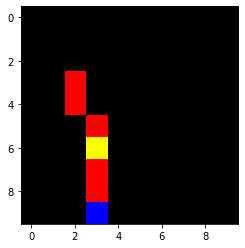

In [ ]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

Interestingly enough, this model is a lot more dynamic and reactive than the other models. This could be a sign that the game is too simple for a larger model, and needs to be trained on a smaller one.

I haven't gotten a chance to use OpenAI gym.